<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

# 푸리에 급수(Fourier Series)와 기저 함수(Basis Functions)

3DGS에서 사용하는 구면 조화 함수(spherical harmonics)를 이해하기 위한 준비 과정입니다.

**왜 이 내용을 공부해야 할까요?**

3D Gaussian Splatting에서는 각 가우시안이 보는 방향에 따라 다른 색상을 표현해야 합니다. 예를 들어, 금속 표면은 보는 각도에 따라 반사되는 빛의 색이 달라집니다. 이러한 **방향에 따라 다르게 보이는 색상(view-dependent color)**을 효율적으로 표현하기 위해 **구면 조화 함수(Spherical Harmonics, SH)**를 사용합니다.

1. **푸리에 급수** (이 노트북): 1차원 신호를 사인/코사인으로 분해하는 기본 개념 습득
2. **2D 푸리에 변환** (다음 노트북): 2차원으로 확장된 주파수 분석 이해  
3. **구면 조화 함수** (최종 목표): 구 표면으로 확장된 기저 함수 활용

**실용적 이점:**
- 메모리 효율: 무한한 방향의 색상 정보를 소수의 SH 계수(보통 9~16개)로 압축
- 계산 효율: 렌더링 시 빠른 색상 계산 가능
- 부드러운 보간: 방향 변화에 따른 자연스러운 색상 전환

푸리에 급수는 이 모든 것의 출발점입니다. "복잡한 것을 간단한 기저 함수들의 조합으로 표현한다"는 핵심 아이디어를 먼저 1차원에서 확실히 이해하고 나면, 이를 3차원 구면으로 확장하는 것이 훨씬 수월해집니다.

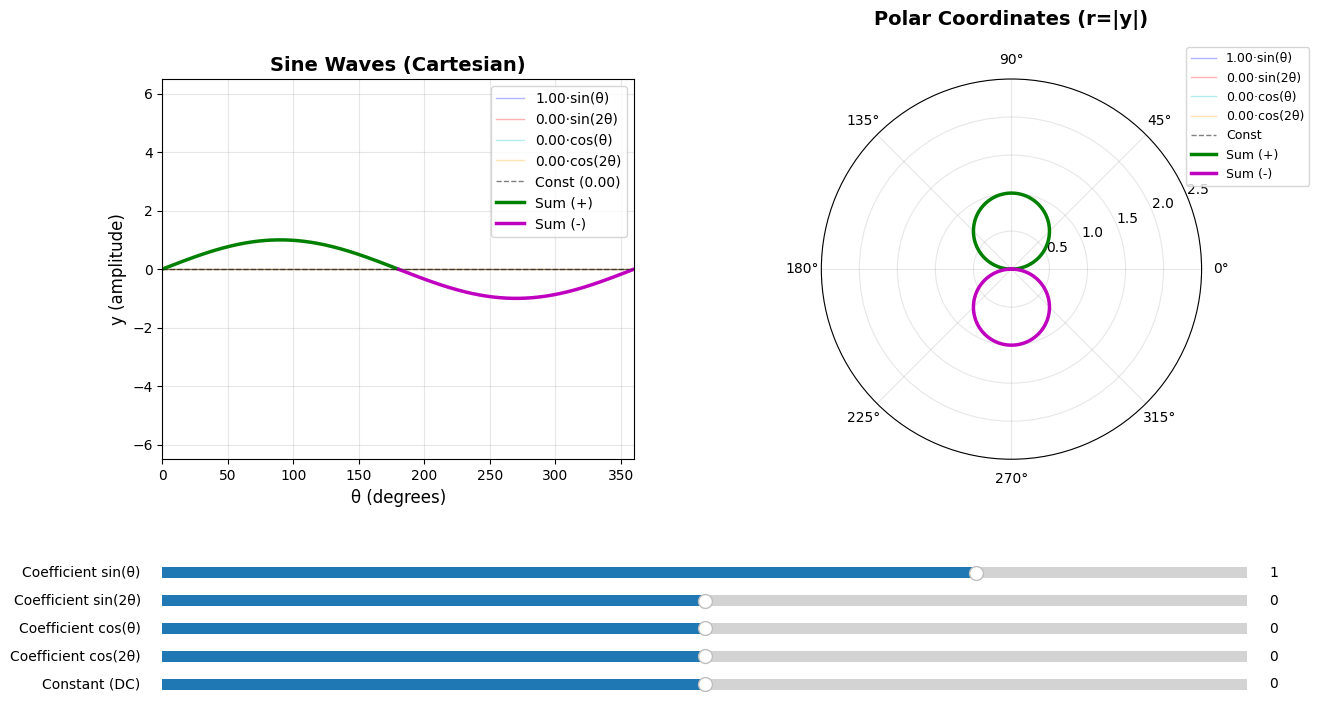

Interactive Sine Wave Combination:
   • Adjust coefficient sliders to control the strength of each component
   • Blue: sin(θ)
   • Red: sin(2θ)
   • Cyan: cos(θ)
   • Orange: cos(2θ)
   • Black Dashed: Constant (DC offset)
   • Green: Sum (Positive values)
   • Magenta: Sum (Negative values)
   • Formula: y = c1·sin(θ) + c2·sin(2θ) + c3·cos(θ) + c4·cos(2θ) + C


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

def plot_interactive_sine_waves():
    # Initial amplitudes
    amp1_init = 1.0
    amp2_init = 0.0
    amp_cos1_init = 0.0
    amp_cos2_init = 0.0
    const_init = 0.0
    
    # Generate sine wave data
    theta = np.linspace(0, 2*np.pi, 500)
    theta_degrees = np.degrees(theta)  # Convert to degrees for display
    x = theta
    
    # Create figure with two subplots
    fig = plt.figure(figsize=(14, 8))
    
    # Create GridSpec for better layout control
    # Top row: 2 plots, Bottom: 5 sliders (each in own row)
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 0.35], hspace=0.4)
    gs_top = gs[0].subgridspec(1, 2, wspace=0.3)
    gs_bot = gs[1].subgridspec(5, 1, hspace=0.3)
    
    ax1 = fig.add_subplot(gs_top[0, 0])
    ax2 = fig.add_subplot(gs_top[0, 1], projection='polar')
    
    # Compute waves function
    def compute_waves(amp1, amp2, amp_cos1, amp_cos2, const):
        y1 = amp1 * np.sin(theta)
        y2 = amp2 * np.sin(2 * theta)
        y_cos1 = amp_cos1 * np.cos(theta)
        y_cos2 = amp_cos2 * np.cos(2 * theta)
        y_const = np.full_like(theta, const)
        y_sum = TODO
        
        # Absolute radius for polar plot
        r1 = np.abs(y1)
        r2 = np.abs(y2)
        r_cos1 = np.abs(y_cos1)
        r_cos2 = np.abs(y_cos2)
        r_const = np.abs(y_const)
        r_sum = np.abs(y_sum)
        
        # Split sum into positive and negative parts for coloring
        y_sum_pos = y_sum.copy()
        y_sum_pos[y_sum < 0] = np.nan
        
        y_sum_neg = y_sum.copy()
        y_sum_neg[y_sum > 0] = np.nan
        
        return y1, y2, y_cos1, y_cos2, y_const, y_sum, r1, r2, r_cos1, r_cos2, r_const, r_sum, y_sum_pos, y_sum_neg
    
    y1, y2, y_cos1, y_cos2, y_const, y_sum, r1, r2, r_cos1, r_cos2, r_const, r_sum, y_sum_pos, y_sum_neg = compute_waves(amp1_init, amp2_init, amp_cos1_init, amp_cos2_init, const_init)
    
    # Left plot: Show y vs theta (Cartesian) with sign coloring
    line1_cart, = ax1.plot(theta_degrees, y1, 'b-', linewidth=1.0, label=f'{amp1_init:.2f}·sin(θ)', alpha=0.3)
    line2_cart, = ax1.plot(theta_degrees, y2, 'r-', linewidth=1.0, label=f'{amp2_init:.2f}·sin(2θ)', alpha=0.3)
    line_cos1_cart, = ax1.plot(theta_degrees, y_cos1, 'c-', linewidth=1.0, label=f'{amp_cos1_init:.2f}·cos(θ)', alpha=0.3)
    line_cos2_cart, = ax1.plot(theta_degrees, y_cos2, 'orange', linewidth=1.0, label=f'{amp_cos2_init:.2f}·cos(2θ)', alpha=0.3)
    line_const_cart, = ax1.plot(theta_degrees, y_const, 'k--', linewidth=1.0, label=f'Const ({const_init:.2f})', alpha=0.5)
    
    # Plot sum with different colors for positive and negative values
    line_sum_pos_cart, = ax1.plot(theta_degrees, y_sum_pos, 'g-', linewidth=2.5, label='Sum (+)')
    line_sum_neg_cart, = ax1.plot(theta_degrees, y_sum_neg, 'm-', linewidth=2.5, label='Sum (-)')
    
    ax1.grid(True, alpha=0.3)
    ax1.set_xlabel('θ (degrees)', fontsize=12)
    ax1.set_ylabel('y (amplitude)', fontsize=12)
    ax1.set_title('Sine Waves (Cartesian)', fontsize=14, fontweight='bold')
    ax1.axhline(y=0, color='k', linewidth=0.5, linestyle='-', alpha=0.5)
    ax1.set_ylim([-6.5, 6.5])
    ax1.set_xlim([0, 360])
    ax1.legend(fontsize=10)
    
    # Right plot: Polar/circular coordinates (theta)
    # Note: We plot r (absolute) but color code based on the sign of y
    line1_polar, = ax2.plot(theta, r1, 'b-', linewidth=1.0, label=f'{amp1_init:.2f}·sin(θ)', alpha=0.3)
    line2_polar, = ax2.plot(theta, r2, 'r-', linewidth=1.0, label=f'{amp2_init:.2f}·sin(2θ)', alpha=0.3)
    line_cos1_polar, = ax2.plot(theta, r_cos1, 'c-', linewidth=1.0, label=f'{amp_cos1_init:.2f}·cos(θ)', alpha=0.3)
    line_cos2_polar, = ax2.plot(theta, r_cos2, 'orange', linewidth=1.0, label=f'{amp_cos2_init:.2f}·cos(2θ)', alpha=0.3)
    line_const_polar, = ax2.plot(theta, r_const, 'k--', linewidth=1.0, label=f'Const', alpha=0.5)
    
    line_sum_pos_polar, = ax2.plot(theta, np.abs(y_sum_pos), 'g-', linewidth=2.5, label='Sum (+)')
    line_sum_neg_polar, = ax2.plot(theta, np.abs(y_sum_neg), 'm-', linewidth=2.5, label='Sum (-)')
    
    ax2.set_title('Polar Coordinates (r=|y|)', fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylim([0, 2.5])
    ax2.grid(True, alpha=0.3)
    # Only show unique labels in legend
    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys(), fontsize=9, loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # Create sliders
    ax_amp1 = fig.add_subplot(gs_bot[0, 0])
    ax_amp2 = fig.add_subplot(gs_bot[1, 0])
    ax_cos1 = fig.add_subplot(gs_bot[2, 0])
    ax_cos2 = fig.add_subplot(gs_bot[3, 0])
    ax_const = fig.add_subplot(gs_bot[4, 0])
    
    slider_amp1 = Slider(ax_amp1, 'Coefficient sin(θ)', -2.0, 2.0, valinit=amp1_init)
    slider_amp2 = Slider(ax_amp2, 'Coefficient sin(2θ)', -2.0, 2.0, valinit=amp2_init)
    slider_cos1 = Slider(ax_cos1, 'Coefficient cos(θ)', -2.0, 2.0, valinit=amp_cos1_init)
    slider_cos2 = Slider(ax_cos2, 'Coefficient cos(2θ)', -2.0, 2.0, valinit=amp_cos2_init)
    slider_const = Slider(ax_const, 'Constant (DC)', -2.0, 2.0, valinit=const_init)
    
    # Update function
    def update(val):
        amp1 = slider_amp1.val
        amp2 = slider_amp2.val
        amp_cos1 = slider_cos1.val
        amp_cos2 = slider_cos2.val
        const = slider_const.val
        
        # Compute new waves
        y1, y2, y_cos1, y_cos2, y_const, y_sum, r1, r2, r_cos1, r_cos2, r_const, r_sum, y_sum_pos, y_sum_neg = compute_waves(amp1, amp2, amp_cos1, amp_cos2, const)
        
        # Update left plot
        line1_cart.set_ydata(y1)
        line2_cart.set_ydata(y2)
        line_cos1_cart.set_ydata(y_cos1)
        line_cos2_cart.set_ydata(y_cos2)
        line_const_cart.set_ydata(y_const)
        line_sum_pos_cart.set_ydata(y_sum_pos)
        line_sum_neg_cart.set_ydata(y_sum_neg)
        
        line1_cart.set_label(f'{amp1:.2f}·sin(θ)')
        line2_cart.set_label(f'{amp2:.2f}·sin(2θ)')
        line_cos1_cart.set_label(f'{amp_cos1:.2f}·cos(θ)')
        line_cos2_cart.set_label(f'{amp_cos2:.2f}·cos(2θ)')
        line_const_cart.set_label(f'Const ({const:.2f})')
        ax1.legend(fontsize=10)
        
        # Update Polar plot
        line1_polar.set_ydata(r1)
        line2_polar.set_ydata(r2)
        line_cos1_polar.set_ydata(r_cos1)
        line_cos2_polar.set_ydata(r_cos2)
        line_const_polar.set_ydata(r_const)
        line_sum_pos_polar.set_ydata(np.abs(y_sum_pos))
        line_sum_neg_polar.set_ydata(np.abs(y_sum_neg))
        
        line1_polar.set_label(f'{amp1:.2f}·sin(θ)')
        line2_polar.set_label(f'{amp2:.2f}·sin(2θ)')
        line_cos1_polar.set_label(f'{amp_cos1:.2f}·cos(θ)')
        line_cos2_polar.set_label(f'{amp_cos2:.2f}·cos(2θ)')
        line_const_polar.set_label(f'Const ({const:.2f})')
        
        fig.canvas.draw_idle()
    
    slider_amp1.on_changed(update)
    slider_amp2.on_changed(update)
    slider_cos1.on_changed(update)
    slider_cos2.on_changed(update)
    slider_const.on_changed(update)
    
    plt.show()
    
    print("Interactive Sine Wave Combination:")
    print("   • Adjust coefficient sliders to control the strength of each component")
    print("   • Blue: sin(θ)")
    print("   • Red: sin(2θ)")
    print("   • Cyan: cos(θ)")
    print("   • Orange: cos(2θ)")
    print("   • Black Dashed: Constant (DC offset)")
    print("   • Green: Sum (Positive values)")
    print("   • Magenta: Sum (Negative values)")
    print("   • Formula: y = c1·sin(θ) + c2·sin(2θ) + c3·cos(θ) + c4·cos(2θ) + C")

plot_interactive_sine_waves()

## 1. 기저 함수(Basis Functions)

비유: 
- **RGB 색깔**: 빨강, 녹색, 파랑 세 가지 색을 다양한 비율로 섞어서 원하는 모든 색을 만들 수 있다.
- **합창단**: 소프라노, 알토, 테너, 베이스 등 다양한 목소리가 각각 다른 음역대를 담당하며, 이들이 함께 어울려 풍부한 화음을 만든다.

**핵심 통찰:** 무한히 많은 색이나 성부가 필요하지 않듯이, 대부분의 신호를 근사하는 데 무한히 많은 기저 함수가 필요하지 않다. 적절히 선택된 몇 개 항만으로도 신호의 본질적인 특징을 충분히 포착할 수 있다.

**기저 함수도 같은 원리로 작동한다:**
- **사인파** $\sin(t), \sin(2t), \sin(3t), ...$ 는 "기본 신호"들이다 (마치 RGB 색이나 합창단의 각 성부처럼)
- 어떤 반복되는 신호든 이 파동들을 섞어서 만들 수 있다
- **계수(Coefficient)** 는 각 기저 함수의 "양(amount)"을 결정한다 (색칠할 때의 물감 양이나 합창단원의 음량처럼)


이 아이디어는 사인과 코사인을 넘어 확장된다:
- **푸리에 급수** (이 노트북): 직선 위의 사인/코사인
- **2D 푸리에** (다음 노트북): 평면 위의 2D 파동
- **구면 조화함수** (최종 목표): 구 위의 특수한 함수들

수식으로 정리하면: **복잡한 신호 = Σ (계수 × 기저 함수)**

In [2]:
# Configure matplotlib for interactive widgets
%matplotlib widget

# If widget backend doesn't work, you can try:
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

# Setup plots to look nice
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [10, 4]

## 2. 삼각함수

The sine and cosine pair can be combined into a single wave with amplitude and phase:

$$
A_n \cos(\omega t + \phi_n) = a_n \cos(\omega t) + b_n \sin(\omega t)
$$

where:
- **진폭(Amplitude)**: $A_n = \sqrt{a_n^2 + b_n^2}$ — how strong the wave is
- **위상 이동(Phase shift)**: $\phi_n = \arctan\left(\frac{-b_n}{a_n}\right)$ — when the peak occurs

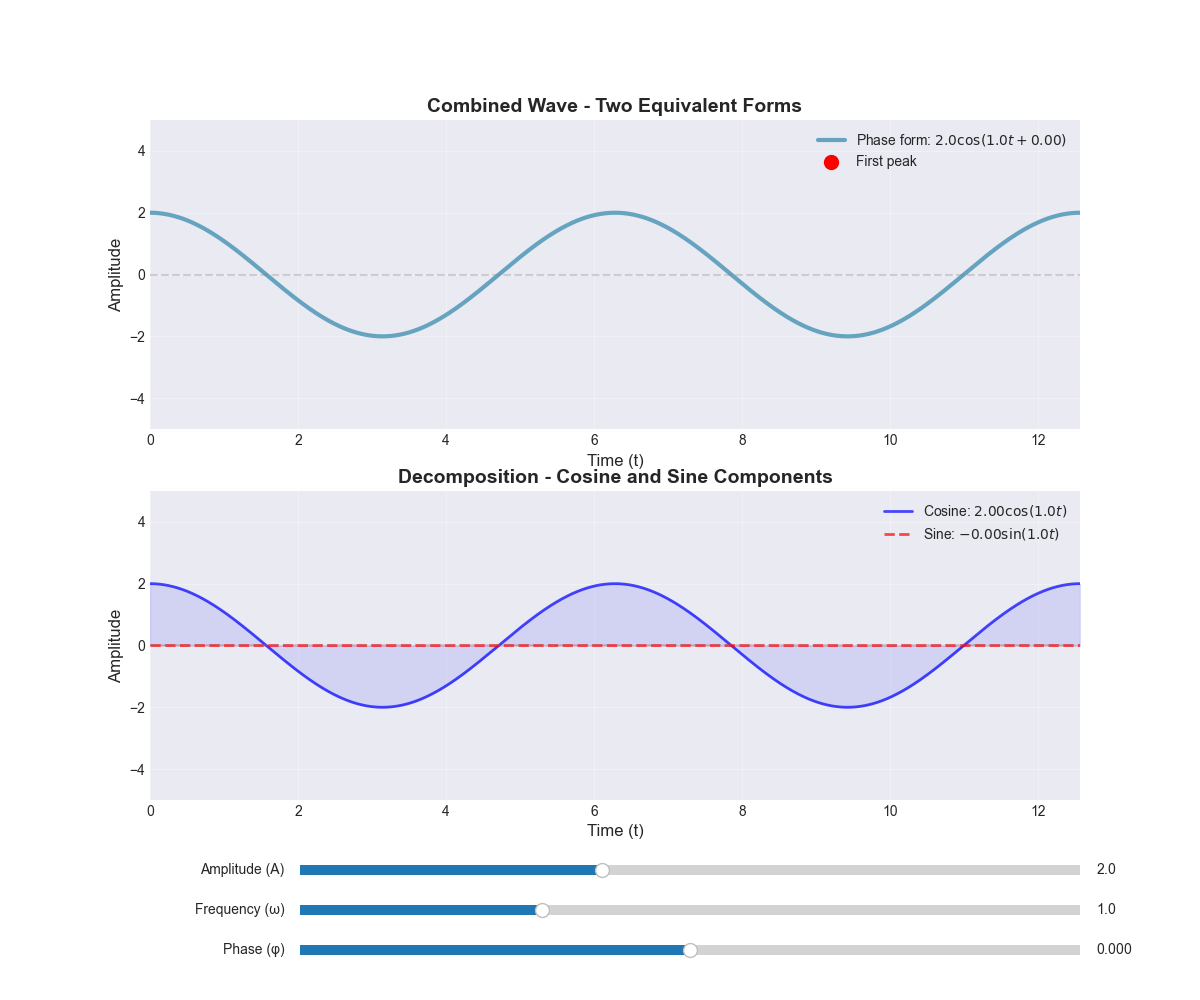

Interactive Exploration:
   • Move Amplitude (A) slider: Change wave height
   • Move Frequency (ω) slider: Change oscillation speed
   • Move Phase (φ) slider: Shift wave left/right in time
   • Verify: A²= a² + b² (amplitude-phase ↔ sine-cosine equivalence)
   • Notice: Blue cosine + Red sine = Combined wave


In [3]:
# Interactive visualization of Amplitude, Frequency, and Phase
from matplotlib.widgets import Slider
import numpy as np
import matplotlib.pyplot as plt

def plot_interactive_wave():
    # Initial parameters
    amplitude_init = 2.0
    omega_init = 1.0
    phase_init = 0.0
    
    t = np.linspace(0, 4*np.pi, 1000)
    
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    plt.subplots_adjust(bottom=0.20)
    
    # Compute initial values
    def compute_wave(amplitude, omega, phase):
        y_phase_form = amplitude * np.cos(omega * t + phase)
        a = amplitude * np.cos(phase)
        b = -amplitude * np.sin(phase)
        y_sincos_form = a * np.cos(omega * t) + b * np.sin(omega * t)
        y_cos = a * np.cos(omega * t)
        y_sin = b * np.sin(omega * t)
        return y_phase_form, y_cos, y_sin, a, b
    
    y_phase, y_cos, y_sin, a_init, b_init = compute_wave(amplitude_init, omega_init, phase_init)
    
    # Top plot: Combined wave
    line_phase, = ax1.plot(t, y_phase, linewidth=3, color='#2E86AB', alpha=0.7,
                           label=rf'Phase form: ${amplitude_init:.1f} \cos({omega_init:.1f}t + {phase_init:.2f})$')
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    peak_marker, = ax1.plot([], [], 'ro', markersize=10, label='First peak')
    ax1.set_title("Combined Wave - Two Equivalent Forms", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Time (t)", fontsize=12)
    ax1.set_ylabel("Amplitude", fontsize=12)
    ax1.set_ylim([-5, 5])
    ax1.set_xlim([0, 4*np.pi])
    ax1.grid(True, alpha=0.3)
    legend1 = ax1.legend(fontsize=10, loc='upper right')
    
    # Bottom plot: Components
    line_cos, = ax2.plot(t, y_cos, 'b-', linewidth=2, alpha=0.7, 
                         label=rf'Cosine: ${a_init:.2f} \cos({omega_init:.1f}t)$')
    line_sin, = ax2.plot(t, y_sin, 'r--', linewidth=2, alpha=0.7, 
                         label=rf'Sine: ${b_init:.2f} \sin({omega_init:.1f}t)$')
    fill_cos = ax2.fill_between(t, 0, y_cos, alpha=0.1, color='blue')
    fill_sin = ax2.fill_between(t, 0, y_sin, alpha=0.1, color='red')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.set_title("Decomposition - Cosine and Sine Components", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Time (t)", fontsize=12)
    ax2.set_ylabel("Amplitude", fontsize=12)
    ax2.set_ylim([-5, 5])
    ax2.set_xlim([0, 4*np.pi])
    ax2.grid(True, alpha=0.3)
    legend2 = ax2.legend(fontsize=10, loc='upper right')
    
    # Create sliders
    ax_amplitude = plt.axes([0.25, 0.12, 0.65, 0.02])
    ax_omega = plt.axes([0.25, 0.08, 0.65, 0.02])
    ax_phase = plt.axes([0.25, 0.04, 0.65, 0.02])
    
    slider_amplitude = Slider(ax_amplitude, 'Amplitude (A)', 0.1, 5.0, valinit=amplitude_init)
    slider_omega = Slider(ax_omega, 'Frequency (ω)', 0.1, 3.0, valinit=omega_init)
    slider_phase = Slider(ax_phase, 'Phase (φ)', -np.pi, np.pi, valinit=phase_init)
    
    # Store fill objects for removal
    fill_objects = [fill_cos, fill_sin]
    
    def update(val):
        amplitude = slider_amplitude.val
        omega = slider_omega.val
        phase = slider_phase.val
        
        # Compute new wave
        y_phase, y_cos, y_sin, a, b = compute_wave(amplitude, omega, phase)
        
        # Update top plot
        line_phase.set_ydata(y_phase)
        line_phase.set_label(rf'Phase form: ${amplitude:.1f} \cos({omega:.1f}t + {phase:.2f})$')
        
        # Update peak marker
        if omega > 0:
            first_peak = (-phase / omega) % (2*np.pi/omega)
            if first_peak < 4*np.pi:
                peak_marker.set_data([first_peak], [amplitude])
                peak_marker.set_label(f'First peak at t={first_peak:.2f}')
            else:
                peak_marker.set_data([], [])
        else:
            peak_marker.set_data([], [])
        
        # Update legend
        ax1.legend(fontsize=10, loc='upper right')
        
        # Update bottom plot
        line_cos.set_ydata(y_cos)
        line_sin.set_ydata(y_sin)
        line_cos.set_label(rf'Cosine: ${a:.2f} \cos({omega:.1f}t)$')
        line_sin.set_label(rf'Sine: ${b:.2f} \sin({omega:.1f}t)$')
        
        # Remove old fills and create new ones
        for fill in fill_objects:
            fill.remove()
        fill_objects[0] = ax2.fill_between(t, 0, y_cos, alpha=0.1, color='blue')
        fill_objects[1] = ax2.fill_between(t, 0, y_sin, alpha=0.1, color='red')
        
        ax2.legend(fontsize=10, loc='upper right')
        
        fig.canvas.draw_idle()
    
    slider_amplitude.on_changed(update)
    slider_omega.on_changed(update)
    slider_phase.on_changed(update)
    
    plt.show()
    
    # Print instructions
    print("Interactive Exploration:")
    print("   • Move Amplitude (A) slider: Change wave height")
    print("   • Move Frequency (ω) slider: Change oscillation speed")
    print("   • Move Phase (φ) slider: Shift wave left/right in time")
    print("   • Verify: A²= a² + b² (amplitude-phase ↔ sine-cosine equivalence)")
    print("   • Notice: Blue cosine + Red sine = Combined wave")

plot_interactive_wave()

## 3. 중첩: 파동들을 함께 더하기

서로 다른 양의 기저 함수들을 더함으로써 복잡한 신호를 만들 수 있다. 이때 기저 함수 앞에 가중치를 곱할 수 있다.

$$ \text{신호} = c_1 \sin(x) + c_2 \sin(2x) + ... = \Sigma_i c_i \sin(ix) $$

예시) 이들을 섞어보자:
*   많은 양의 `sin(x)` (계수 = 1.0)
*   조금의 `sin(3x)` (계수 = 0.5)
*   아주 조금의 `sin(5x)` (계수 = 0.3)

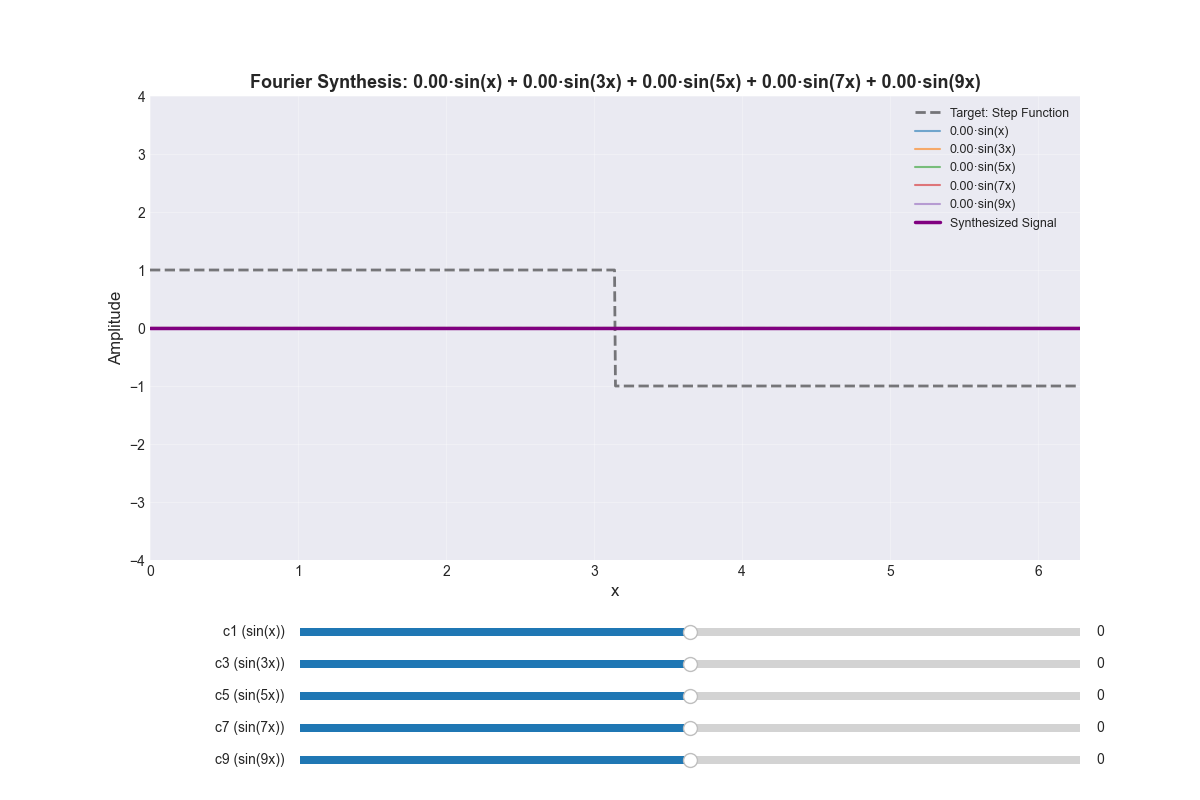

Interactive Fourier Synthesis:
   • Black dashed line: Target step function (amplitude ±1.5)
   • Adjust c1 slider: Control amplitude of sin(x) - fundamental frequency
   • Adjust c3 slider: Control amplitude of sin(3x) - 3rd harmonic
   • Adjust c5 slider: Control amplitude of sin(5x) - 5th harmonic
   • Adjust c7 slider: Control amplitude of sin(7x) - 7th harmonic
   • Adjust c9 slider: Control amplitude of sin(9x) - 9th harmonic
   • Purple line: Sum of all components (synthesized signal)
   • Experiment: Try c1=1.91, c3=0.64, c5=0.38, c7=0.27, c9=0.21 to approximate the step function


In [4]:
# Interactive Fourier Synthesis with Sliders
from matplotlib.widgets import Slider

def plot_interactive_fourier_synthesis():
    # Initial coefficients
    c1_init = 0.0
    c3_init = 0.0
    c5_init = 0.0
    c7_init = 0.0
    c9_init = 0.0
    
    # Define x values for plotting
    x = np.linspace(0, 2*np.pi, 1000)
    
    # Create step function (target function to approximate)
    step_function = np.where(x < np.pi, 1.0, -1.0)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.subplots_adjust(bottom=0.30)
    
    # Compute initial waves
    def compute_waves(c1, c3, c5, c7, c9):
        wave1 = c1 * np.sin(1*x)
        wave3 = c3 * np.sin(3*x)
        wave5 = c5 * np.sin(5*x)
        wave7 = c7 * np.sin(7*x)
        wave9 = c9 * np.sin(9*x)
        complex_signal = wave1 + wave3 + wave5 + wave7 + wave9
        return wave1, wave3, wave5, wave7, wave9, complex_signal
    
    wave1, wave3, wave5, wave7, wave9, complex_signal = compute_waves(c1_init, c3_init, c5_init, c7_init, c9_init)
    
    # Plot step function (target)
    ax.plot(x, step_function, 'k--', linewidth=2, alpha=0.5, label='Target: Step Function', zorder=1)
    
    # Initial plot
    line1, = ax.plot(x, wave1, linewidth=1.5, alpha=0.6, label=f'{c1_init:.2f}·sin(x)')
    line3, = ax.plot(x, wave3, linewidth=1.5, alpha=0.6, label=f'{c3_init:.2f}·sin(3x)')
    line5, = ax.plot(x, wave5, linewidth=1.5, alpha=0.6, label=f'{c5_init:.2f}·sin(5x)')
    line7, = ax.plot(x, wave7, linewidth=1.5, alpha=0.6, label=f'{c7_init:.2f}·sin(7x)')
    line9, = ax.plot(x, wave9, linewidth=1.5, alpha=0.6, label=f'{c9_init:.2f}·sin(9x)')
    line_sum, = ax.plot(x, complex_signal, color='purple', linewidth=2.5, label='Synthesized Signal', zorder=10)
    
    ax.set_title(f"Fourier Synthesis: {c1_init:.2f}·sin(x) + {c3_init:.2f}·sin(3x) + {c5_init:.2f}·sin(5x) + {c7_init:.2f}·sin(7x) + {c9_init:.2f}·sin(9x)", 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    ax.set_ylim([-4, 4])
    ax.set_xlim([0, 2*np.pi])
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Create sliders
    ax_c1 = plt.axes([0.25, 0.20, 0.65, 0.02])
    ax_c3 = plt.axes([0.25, 0.16, 0.65, 0.02])
    ax_c5 = plt.axes([0.25, 0.12, 0.65, 0.02])
    ax_c7 = plt.axes([0.25, 0.08, 0.65, 0.02])
    ax_c9 = plt.axes([0.25, 0.04, 0.65, 0.02])
    
    slider_c1 = Slider(ax_c1, 'c1 (sin(x))', -2.0, 2.0, valinit=c1_init)
    slider_c3 = Slider(ax_c3, 'c3 (sin(3x))', -2.0, 2.0, valinit=c3_init)
    slider_c5 = Slider(ax_c5, 'c5 (sin(5x))', -2.0, 2.0, valinit=c5_init)
    slider_c7 = Slider(ax_c7, 'c7 (sin(7x))', -2.0, 2.0, valinit=c7_init)
    slider_c9 = Slider(ax_c9, 'c9 (sin(9x))', -2.0, 2.0, valinit=c9_init)
    
    # Update function
    def update(val):
        c1 = slider_c1.val
        c3 = slider_c3.val
        c5 = slider_c5.val
        c7 = slider_c7.val
        c9 = slider_c9.val
        
        # Compute new waves
        wave1, wave3, wave5, wave7, wave9, complex_signal = compute_waves(c1, c3, c5, c7, c9)
        
        # Update plot data
        line1.set_ydata(wave1)
        line3.set_ydata(wave3)
        line5.set_ydata(wave5)
        line7.set_ydata(wave7)
        line9.set_ydata(wave9)
        line_sum.set_ydata(complex_signal)
        
        # Update labels
        line1.set_label(f'{c1:.2f}·sin(x)')
        line3.set_label(f'{c3:.2f}·sin(3x)')
        line5.set_label(f'{c5:.2f}·sin(5x)')
        line7.set_label(f'{c7:.2f}·sin(7x)')
        line9.set_label(f'{c9:.2f}·sin(9x)')
        
        # Update title and legend
        ax.set_title(f"Fourier Synthesis: {c1:.2f}·sin(x) + {c3:.2f}·sin(3x) + {c5:.2f}·sin(5x) + {c7:.2f}·sin(7x) + {c9:.2f}·sin(9x)", 
                     fontsize=13, fontweight='bold')
        ax.legend(fontsize=9, loc='upper right')
        
        fig.canvas.draw_idle()
    
    slider_c1.on_changed(update)
    slider_c3.on_changed(update)
    slider_c5.on_changed(update)
    slider_c7.on_changed(update)
    slider_c9.on_changed(update)
    
    plt.show()
    
    print("Interactive Fourier Synthesis:")
    print("   • Black dashed line: Target step function (amplitude ±1.5)")
    print("   • Adjust c1 slider: Control amplitude of sin(x) - fundamental frequency")
    print("   • Adjust c3 slider: Control amplitude of sin(3x) - 3rd harmonic")
    print("   • Adjust c5 slider: Control amplitude of sin(5x) - 5th harmonic")
    print("   • Adjust c7 slider: Control amplitude of sin(7x) - 7th harmonic")
    print("   • Adjust c9 slider: Control amplitude of sin(9x) - 9th harmonic")
    print("   • Purple line: Sum of all components (synthesized signal)")
    print("   • Experiment: Try c1=1.91, c3=0.64, c5=0.38, c7=0.27, c9=0.21 to approximate the step function")

plot_interactive_fourier_synthesis()

## 4. 서울 온도 데이터

Real-world periodic data: Monthly average temperature in Seoul over 3 years.

In [5]:
# Load Seoul temperature data (daily measurements over 3 years)
# Data source: Run fetch_seoul_temperature.py to download
import os
import pandas as pd
import numpy as np

data_path = 'data/seoul_temperature_daily.csv'

if not os.path.exists(data_path):
    print(f"⚠️ Warning: Data file not found at {data_path}")
    print("Please run: python fetch_seoul_temperature.py")
    print("Continuing with synthetic data for demonstration...\n")
    
    # Generate synthetic temperature data (sinusoidal pattern)
    time_days = np.arange(365 * 3)  # 3 years
    temps = 13 + 15 * np.sin(2*np.pi*time_days/365 - np.pi/2)  # Annual cycle
    temps += np.random.normal(0, 2, len(temps))  # Add noise
else:
    temps_df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    temps = temps_df['tavg'].values
    time_days = np.arange(len(temps))

print(f"Data points: {len(temps)} days over {len(temps)/365:.1f} years")
print(f"Temperature range: {temps.min():.1f}°C to {temps.max():.1f}°C")

Data points: 1095 days over 3.0 years
Temperature range: -10.5°C to 32.7°C


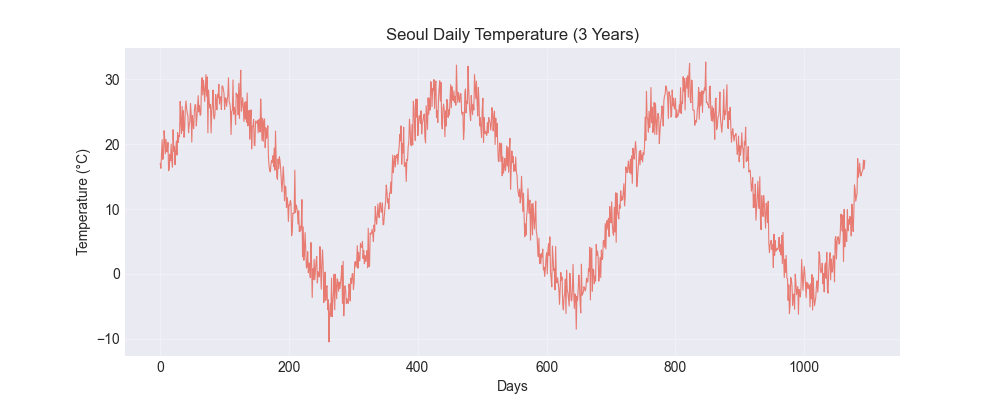

In [6]:
# Plot raw temperature data
plt.figure(figsize=[10, 4])
plt.plot(time_days, temps, '-', color='#E74C3C', linewidth=0.8, alpha=0.7)
plt.title("Seoul Daily Temperature (3 Years)")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.grid(True, alpha=0.3)
plt.show()

### Discrete Fourier Analysis: How to Extract Coefficients

Given sampled data (temperature measurements), we can compute the Fourier coefficients using:

$$a_n = \frac{2}{N} \sum_{k=0}^{N-1} f_k \cos\left(\frac{2\pi n k}{T}\right)$$

$$b_n = \frac{2}{N} \sum_{k=0}^{N-1} f_k \sin\left(\frac{2\pi n k}{T}\right)$$

where:
- $N$ = number of data points (e.g., 1095 daily measurements)
- $T$ = total period of the data (e.g., 1095 days)
- $f_k$ = the data value at sample $k$ (e.g., temperature on day $k$)
- $n$ = harmonic index (1, 2, 3, ... determines the frequency)

The algorithm multiplies the signal by sine and cosine waves of different frequencies and averages the results. **High values indicate that frequency strongly present in the data.**

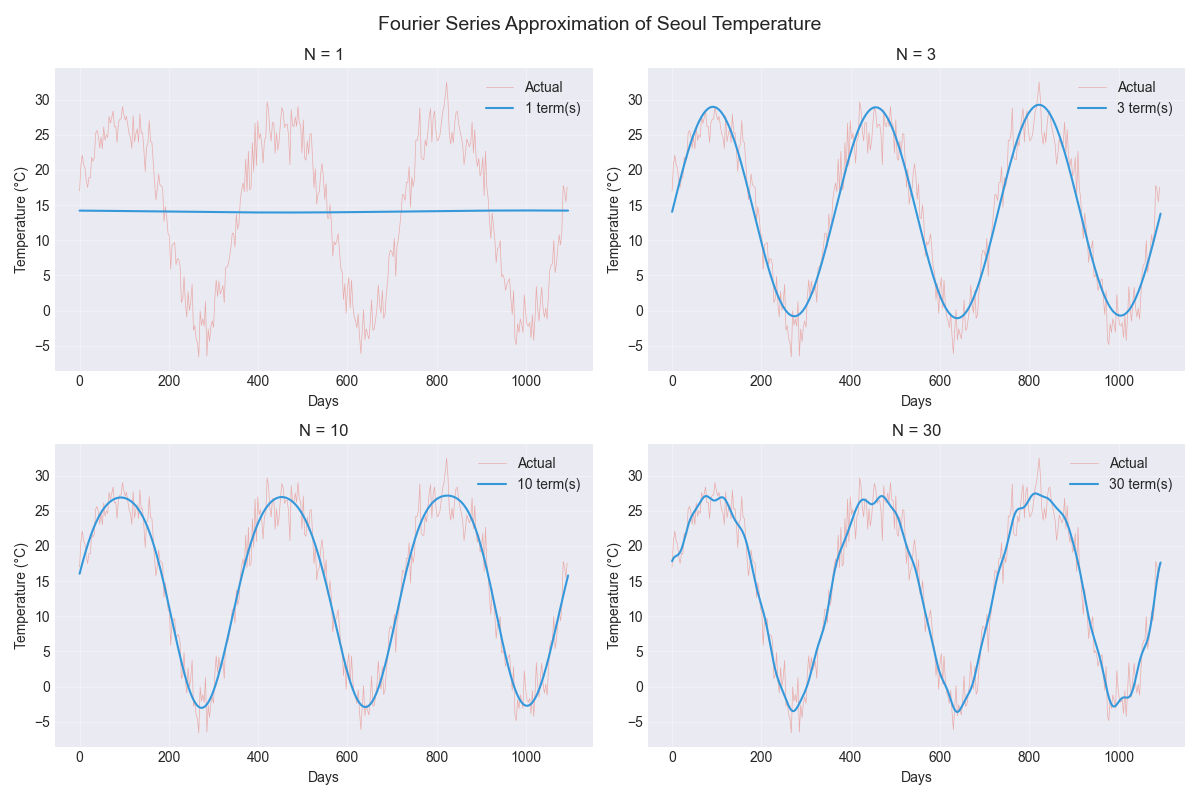

In [7]:
# Fourier series approximation function for temperature
def fourier_approx(t, temps, num_terms):
    """Approximate temperature data using Fourier series"""
    N = len(temps)
    T = N  # Period in days (365*3 for 3 years)
    
    # Mean (DC component)
    a0 = np.mean(temps)
    
    # Build approximation
    approx = np.ones_like(t) * a0
    
    for n in range(1, num_terms + 1):
        # Compute coefficients using discrete Fourier analysis
        an = 2/N * np.sum(temps * np.cos(2*np.pi*n*np.arange(N)/T))
        bn = 2/N * np.sum(temps * np.sin(2*np.pi*n*np.arange(N)/T))
        
        # Add harmonic
        approx += an * np.cos(2*np.pi*n*t/T) + bn * np.sin(2*np.pi*n*t/T)
    
    return approx

# Create smooth time array for plotting
t_smooth = np.linspace(0, len(temps)-1, 1000)

# Plot progressive approximation
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Fourier Series Approximation of Seoul Temperature", fontsize=14)

for idx, num_terms in enumerate([1, 3, 10, 30]):
    ax = axes[idx // 2, idx % 2]
    
    # Original data (subsample for clarity)
    ax.plot(time_days[::3], temps[::3], '-', color='#E74C3C', linewidth=0.5, alpha=0.4, label='Actual')
    
    # Fourier approximation
    approx = fourier_approx(t_smooth, temps, num_terms)
    ax.plot(t_smooth, approx, '-', color='#3498DB', linewidth=1.5, label=f'{num_terms} term(s)')
    
    ax.set_title(f'N = {num_terms}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

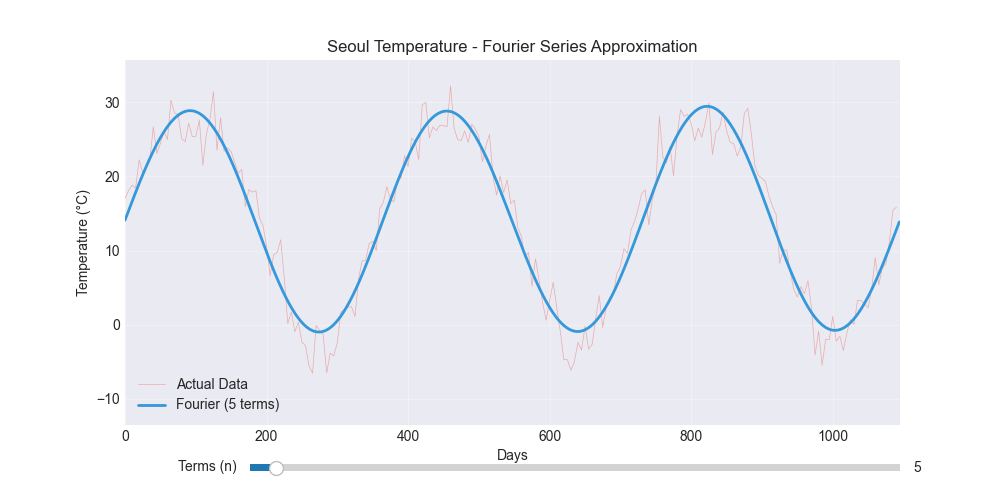

Understanding 'Terms' (frequency index n):
Our data has period T = 1095 days (3 years)
- Term n = 1: 1 complete cycle over T → 1095-day period (captures 3-year trend)
- Term n = 3: 3 complete cycles over T → 365-day period (annual cycle!)
- Term n = 6: 6 complete cycles over T → 182.5-day period (semi-annual)
- Term n = 30: 30 complete cycles over T → 36.5-day period (monthly variations)
- Term n = 100: 100 complete cycles over T → 10.95-day period (weather patterns)

Why Term 3 is the annual cycle: 3 cycles over 3 years = 1 cycle per year
With 1095 daily samples, we could theoretically use up to ~547 terms (Nyquist limit)


In [8]:
# Interactive widget using matplotlib sliders
from matplotlib.widgets import Slider

def plot_interactive_temperature_fourier():
    # Initial number of terms
    num_terms_init = 5
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.subplots_adjust(bottom=0.15)
    
    # Original data (subsample for clarity)
    line_actual, = ax.plot(time_days[::5], temps[::5], '-', color='#E74C3C', 
                           linewidth=0.5, alpha=0.4, label='Actual Data')
    
    # Initial Fourier approximation
    approx_init = fourier_approx(t_smooth, temps, num_terms_init)
    line_fourier, = ax.plot(t_smooth, approx_init, '-', color='#3498DB', 
                            linewidth=2, label=f'Fourier ({num_terms_init} terms)')
    
    ax.set_title("Seoul Temperature - Fourier Series Approximation", fontsize=12)
    ax.set_xlabel("Days")
    ax.set_ylabel("Temperature (°C)")
    ax.set_ylim([temps.min()-3, temps.max()+3])
    ax.set_xlim([0, len(temps)])
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Create slider
    ax_slider = plt.axes([0.25, 0.05, 0.65, 0.03])
    slider_terms = Slider(ax_slider, 'Terms (n)', 1, 100, valinit=num_terms_init, valstep=1)
    
    def update(val):
        num_terms = int(slider_terms.val)
        
        # Compute new approximation
        approx = fourier_approx(t_smooth, temps, num_terms)
        line_fourier.set_ydata(approx)
        line_fourier.set_label(f'Fourier ({num_terms} terms)')
        
        ax.legend()
        fig.canvas.draw_idle()
    
    slider_terms.on_changed(update)
    plt.show()
    
    print("Understanding 'Terms' (frequency index n):")
    print("Our data has period T = 1095 days (3 years)")
    print("- Term n = 1: 1 complete cycle over T → 1095-day period (captures 3-year trend)")
    print("- Term n = 3: 3 complete cycles over T → 365-day period (annual cycle!)")
    print("- Term n = 6: 6 complete cycles over T → 182.5-day period (semi-annual)")
    print("- Term n = 30: 30 complete cycles over T → 36.5-day period (monthly variations)")
    print("- Term n = 100: 100 complete cycles over T → 10.95-day period (weather patterns)")
    print("")
    print("Why Term 3 is the annual cycle: 3 cycles over 3 years = 1 cycle per year")
    print(f"With {len(temps)} daily samples, we could theoretically use up to ~{len(temps)//2} terms (Nyquist limit)")

plot_interactive_temperature_fourier()

**Fourier Series Formula:**

The general Fourier series for our temperature data (with period $T = 1095$ days):

$$
f(t) = a_0 + \sum_{n=1}^{N} \left[ a_n \cos\left(\frac{2\pi n t}{T}\right) + b_n \sin\left(\frac{2\pi n t}{T}\right) \right]
$$

**First 5 terms explicitly:**

$$
\begin{align}
f(t) &= a_0 \quad \text{(average temperature)} \\
&+ a_1 \cos\left(\frac{2\pi t}{1095}\right) + b_1 \sin\left(\frac{2\pi t}{1095}\right) \quad \text{(3-year cycle)} \\
&+ a_2 \cos\left(\frac{4\pi t}{1095}\right) + b_2 \sin\left(\frac{4\pi t}{1095}\right) \quad \text{(18-month cycle)} \\
&+ a_3 \cos\left(\frac{6\pi t}{1095}\right) + b_3 \sin\left(\frac{6\pi t}{1095}\right) \quad \text{(1-year cycle)} \\
&+ a_4 \cos\left(\frac{8\pi t}{1095}\right) + b_4 \sin\left(\frac{8\pi t}{1095}\right) \quad \text{(9-month cycle)} \\
&+ a_5 \cos\left(\frac{10\pi t}{1095}\right) + b_5 \sin\left(\frac{10\pi t}{1095}\right) \quad \text{(7-month cycle)} \\
&+ \ldots
\end{align}
$$

Each term adds a sine and cosine wave at frequency $n$. The coefficients $a_n$ and $b_n$ determine the amplitude and phase.